# Chapter 8 - Recap

In [4]:
library(rethinking)
data(rugged)
d <- rugged

d$log_gdp <- log(d$rgdppc_2000)
dd <- d[complete.cases(d$rgdppc_2000), ]

dd$log_gdp_std <- dd$log_gdp/mean(dd$log_gdp)
dd$rugged_std <- dd$rugged/max(dd$rugged)

In [16]:
m8.1a <- quap(
    alist(
        log_gdp_std ~ dnorm(mu, sigma),
        mu <- a + b*(rugged_std - 0.215),
        a ~ dnorm(1, 1),
        b ~ dnorm(0, 1),
        sigma ~ dexp(1)
    ), data=dd
)

In [14]:
plot_prior <- function(model){
    set.seed(7)
    prior <- extract.prior(model)
    plot(
        NULL, 
        xlim=c(0,1), 
        ylim=c(0.5, 1.5),
        xlab="ruggedness",
        ylab="log GDP")
    abline(h=min(dd$log_gdp_std), lty=3) # marking "impossible territory"
    abline(h=max(dd$log_gdp_std), lty=3)

    rugged_seq <- seq(from=-0.1, to=1.1, length.out=30)
    mu <- link(model, post=prior, data=data.frame(rugged_std=rugged_seq))
    for (i in 1:50) lines(rugged_seq, mu[i,], col=col.alpha("black", 0.3))
    abline(v=0.215, lty=2) # marking the averages on x and y
    abline(h=1, lty=2)
    }

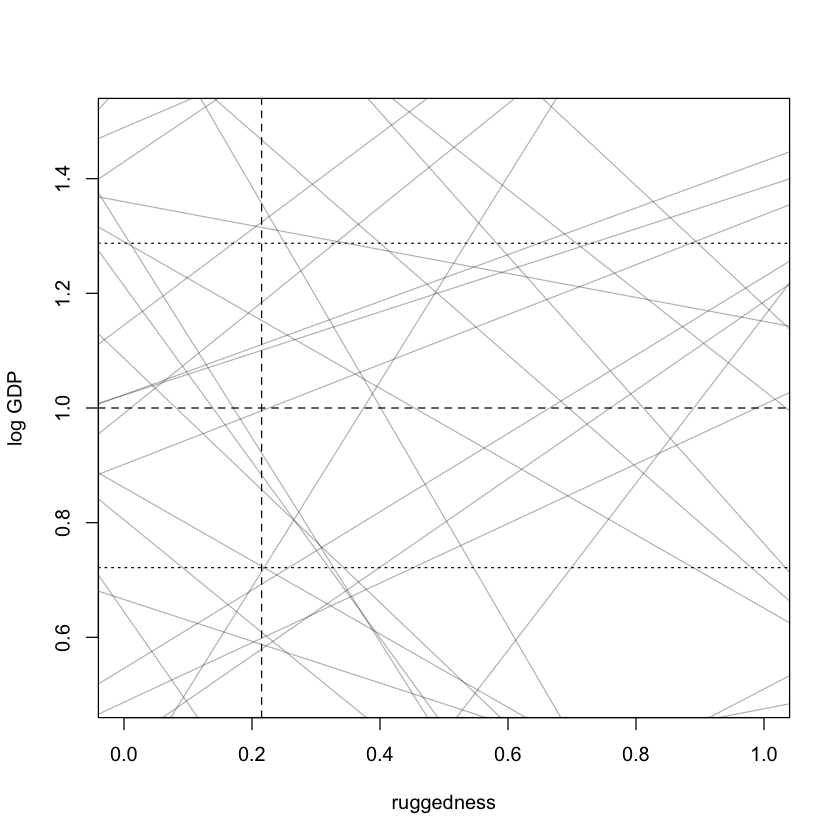

In [17]:
plot_prior(m8.1a)

The plot shows that priors for a and b are implausible:
* a very steep slope (b) means that variance in ruggedness explains most of the variance in GDP. There are many more factors that influence GDP so ruggedness may be at best one of the factors that influence GDP to some degree. -> tighten the prior for b
* the prior for a allows average GDP to lie outside of the observed ranges. The lines need to pass closer to the point where ruggedness is average and log GDP is 1.

In [19]:
m8.1b <- quap(
    alist(
        log_gdp_std ~ dnorm(mu, sigma),
        mu <- a + b*(rugged_std - 0.215),
        a ~ dnorm(1, .1),
        b ~ dnorm(0, .3),
        sigma ~ dexp(1)
    ), data=dd
)

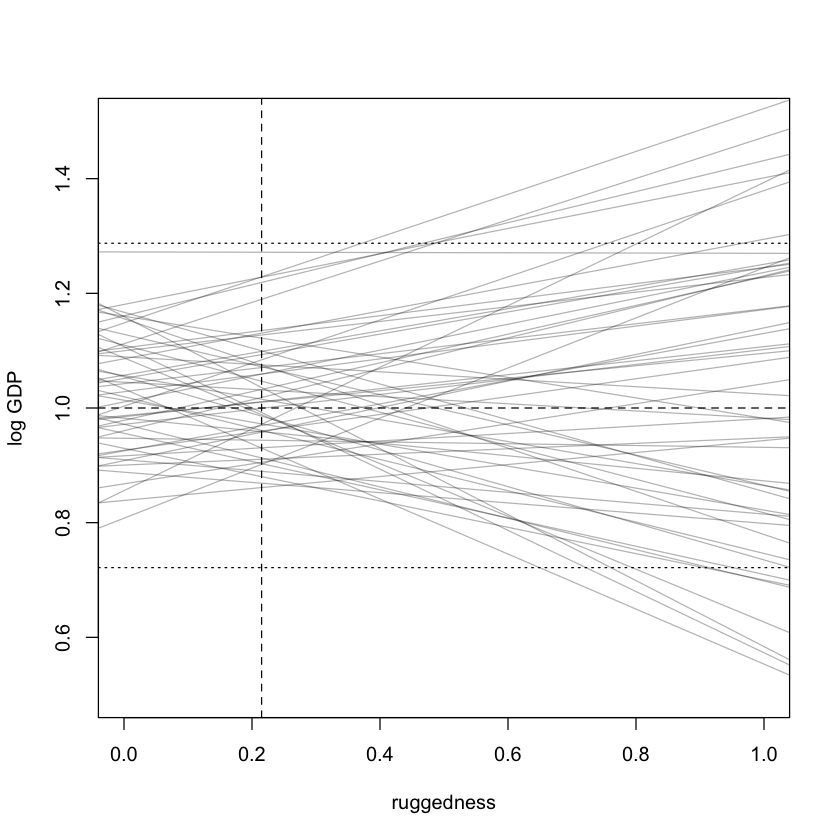

In [20]:
plot_prior(m8.1b)

We now allow the model to have different intercepts for continents:

In [24]:
dd$cid <- ifelse(dd$cont_africa==1, 1, 2)

In [25]:
m8.2 <- quap(
    alist(
        log_gdp_std ~ dnorm(mu, sigma),
        mu <- a[cid] + b*(rugged_std - 0.215),
        a[cid] ~ dnorm(1, .1),
        b ~ dnorm(0, .3),
        sigma ~ dexp(1)
    ), data=dd 
)

In [26]:
compare(m8.1b, m8.2)

,WAIC,SE,dWAIC,dSE,pWAIC,weight
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
m8.2,-251.6373,15.38175,0.00000,NA,4.553194,1.000000e+00
m8.1b,-188.7408,13.28044,62.89657,15.12995,2.683080,2.198789e-14


In [28]:
precis(m8.2, depth=2)

,mean,sd,5.5%,94.5%
,<dbl>,<dbl>,<dbl>,<dbl>
a[1],0.88042692,0.015937787,0.8549553,0.90589858
a[2],1.04915511,0.010186048,1.0328758,1.06543438
b,-0.04644292,0.045688923,-0.1194626,0.02657681
sigma,0.11239282,0.006091818,0.1026569,0.12212872


In [29]:
post <- extract.samples(m8.2)
diff_a1_a2 <- post$a[,1] - post$a[,2]
PI(diff_a1_a2)

5%        94% 
-0.1996293 -0.1383047

In [54]:
plot_posterior_interaction <- function(model){
    rugged.seq <- seq(-0.1, 1.1, length.out=30)
    mu.NotAfrica <- link(model, data=data.frame(cid=2, rugged_std=rugged.seq))
    mu.Africa <- link(model, data=data.frame(cid=1, rugged_std=rugged.seq))

    mu.NotAfrica_mu <- apply(mu.NotAfrica, 2, mean)
    mu.Africa_mu <- apply(mu.Africa, 2, mean)

    plot(
        log_gdp_std~rugged_std,
        data=dd,
        xlim=c(0,1), 
        ylim=c(0.5, 1.5), 
        xlab="ruggedness", 
        ylab="log GDP",
        col=ifelse(cid==1, "blue", "black")
    )
    lines(rugged.seq, mu.NotAfrica_mu)
    lines(rugged.seq, mu.Africa_mu, col="blue")

    mu.NotAfrica_ci <- apply(mu.NotAfrica, 2, PI)
    mu.Africa_ci <- apply(mu.Africa, 2, PI)

    shade(mu.NotAfrica_ci, rugged.seq)
    shade(mu.Africa_ci, rugged.seq, col=col.alpha("blue", 0.1))
    }

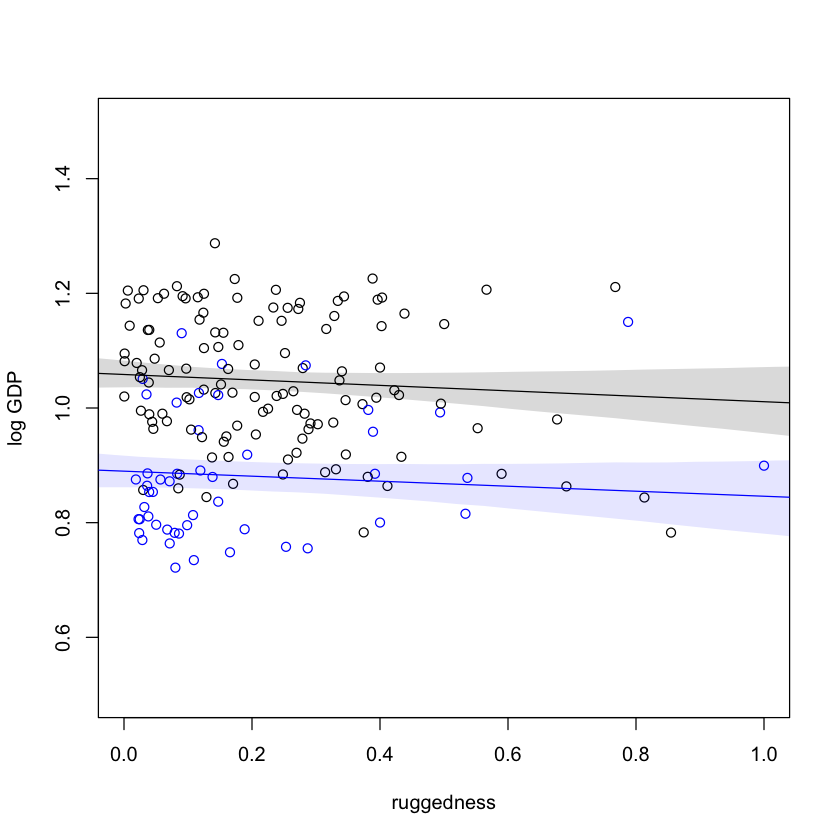

In [55]:
plot_posterior_interaction(m8.2)

In [62]:
m8.3 <- quap(
    alist(
        log_gdp_std ~ dnorm(mu, sigma),
        mu <- a[cid] + b[cid]*(rugged_std - 0.215),
        a[cid] ~ dnorm(1, .1),
        b[cid] ~ dnorm(0, .3),
        sigma ~ dexp(1)
    ), data=dd 
)

In [63]:
precis(m8.3, depth=2)

,mean,sd,5.5%,94.5%
,<dbl>,<dbl>,<dbl>,<dbl>
a[1],0.8865624,0.015674789,0.86151106,0.91161374
a[2],1.0505701,0.009936024,1.03469046,1.06644983
b[1],0.1324676,0.074200356,0.01388113,0.25105413
b[2],-0.1425759,0.054746271,-0.23007106,-0.05508083
sigma,0.1094876,0.005934421,0.10000328,0.11897199


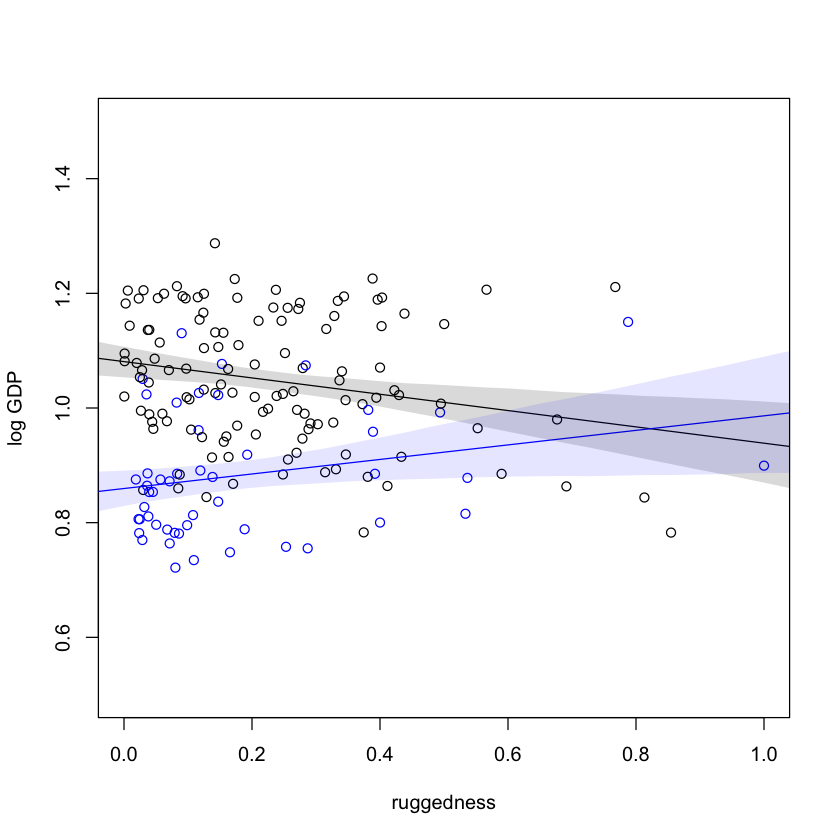

In [64]:
plot_posterior_interaction(m8.3)

In [65]:
compare(m8.1, m8.2, m8.3, func=PSIS)

Some Pareto k values are high (>0.5). Set pointwise=TRUE to inspect individual points.



,PSIS,SE,dPSIS,dSE,pPSIS,weight
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
m8.3,-258.8259,15.20648,0.000000,NA,5.278141,9.681888e-01
m8.2,-251.9947,15.40891,6.831217,6.586771,4.372034,3.181121e-02
m8.1,-188.7579,13.28937,70.068007,15.379287,2.674537,5.900457e-16


Some Pareto k values are high (>0.5). Set pointwise=TRUE to inspect individual points.



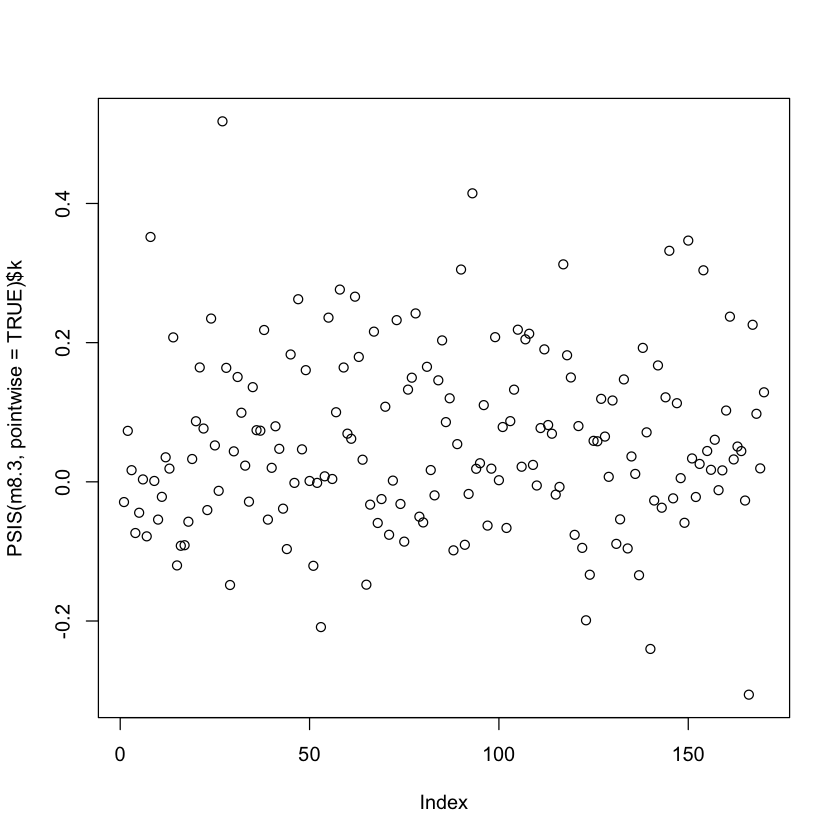

In [66]:
plot(PSIS(m8.3, pointwise=TRUE)$k)